In [1]:
import nonlindyn as nld
import numpy as np
import matplotlib.pyplot as plt
import itertools as it

# Lorenz System

Let us implement the standard [Lorenz System](https://en.wikipedia.org/wiki/Lorenz_system) given by 
\begin{aligned}{\frac {\mathrm {d} x}{\mathrm {d} t}}&=\sigma (y-x),\\
{\frac {\mathrm {d} y}{\mathrm {d} t}}&=x(\rho -z)-y,\\
{\frac {\mathrm {d} z}{\mathrm {d} t}}&=xy-\beta z.
\end{aligned}
with standard parameters 
$$
\sigma = 10; \beta= 8/3; \rho=28
$$



In [2]:
def Lorenz(X, sigma=10., beta=8/3., rho=28.):
    x,y,z = X
    dx = sigma * (y - x)
    dy = x * (rho -z) - y
    dz = x * y - beta * z
    return np.array([dx, dy, dz])

In [3]:
X0 = np.array([1.0,1.0,1.0])
T, X = nld.rk4trajectory(Lorenz, X0,  step=0.01, stop=100.0)

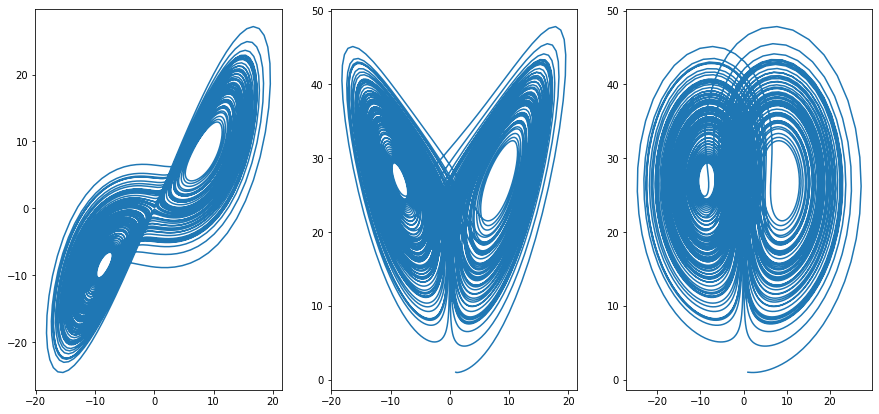

In [4]:
fig, axs = plt.subplots(1, 3, figsize=(15,7))
axs[0].plot(X[:,0], X[:,1])
axs[1].plot(X[:,0], X[:,2])
axs[2].plot(X[:,1], X[:,2])

# Functional approach

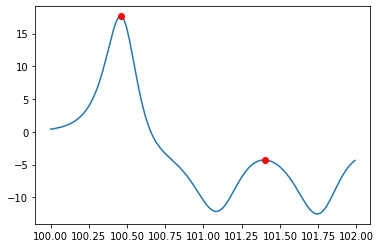

In [6]:
Xinit = np.array([1.,1.,1.])
LS = nld.rk4yield(Lorenz, Xinit, step=0.01) # Generator
LS = it.dropwhile(lambda x: x[0] < 100.0, LS) # Cut off transient
LS = it.takewhile(lambda x: x[0] < 102.0, LS) # Cut tail

LS = list(LS)
LSMAX = nld.filter_max(iter(LS))
T, X = map(np.array, zip(*LS))
Tmax, Xmax = map(np.array, zip(*LSMAX))

plt.plot(T, X[:,0])
plt.plot(Tmax, Xmax[:,0],"ro")